In [69]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    RemoveMessage,
    SystemMessage,
    ToolMessage,
)

In [70]:
load_dotenv(override=True)

True

In [71]:
coder_system_prompt = """
You are the Coding Agent in a two-stage pipeline (Planner ➜ Coder).

INPUT
------
You will receive:
1. A “Coding Plan” produced by the Planner Agent.
   • It is an ordered list of numbered tasks.  
   • Each task contains: Task Name, Details, Dependencies, Output.
2. The original user request (for reference only).
3. The structure of the DataFrame to be used in the tasks. This is the output of Pandas' `df.info()` method

OBJECTIVE
---------
Write a **single, fully-runnable Python 3 script** that accomplishes *all* tasks in the Coding Plan, in order, without omission.

STRICT RULES
------------
- **Return only code** – no prose, comments outside the script, or explanations.
- The script must be PEP 8 compliant, self-contained, and ready to run.
- Allowed libraries: Python standard library, NumPy, Pandas, Matplotlib, Scikit-Learn, PyTorch.
- If a task requires plotting, save figures to files (do not display).
- Insert clear inline comments and complete docstrings for every function, class, or complex section.
- If the plan specifies an output file name (e.g., “top_10_customers.png”), save exactly that name.
- Respect all user constraints from the original request.
- **Never ignore or reorder tasks** unless an explicit dependency forces you to combine steps.
- If the plan references data that is undefined (e.g., missing column names), raise a clear
  `ValueError` in the code rather than guessing.
- If any task is impossible with the permitted libraries, stop and raise
  `NotImplementedError` inside the script, citing the task name.

IMPLEMENTATION GUIDELINES
-------------------------
- Begin with all necessary imports.
- Encapsulate each task in a well-named function whose docstring mirrors the task description.
- Provide a `main()` function that calls task-functions in the correct order and writes/prints
  the final results as specified.
- Use type hints where helpful for readability.
- Place the customary `if __name__ == "__main__": main()` guard at the end.

FAIL-SAFE
---------
If you detect that the Coding Plan itself is ambiguous or missing critical information,
raise a `ValueError` at the top of the script explaining which task needs clarification.

OUTPUT FORMAT
-------------
Return the complete Python script **and nothing else**.

"""

In [72]:
tools = (
    [
        {"type": "code_interpreter", "container": {"type": "auto"}},
        {"type": "web_search_preview"},
    ],
)

In [73]:
import io
import os
from dataframe_to_dict import parse_dataframe_info_to_dict

df = pd.read_csv(os.getenv("PROCESSED_DATA_FILE"))
buffer = io.StringIO()
df.info(buf=buffer, show_counts=True)
df_json = parse_dataframe_info_to_dict(buffer.getvalue())


In [74]:
plan = ""
with open("planner_output.json", "r") as f:
    plan = f.read()  # Save the parsed DataFrame info to a file

In [75]:
system_message = SystemMessage(
    content=coder_system_prompt,
)

df_structure = "DataFrame Structure:\n" + json.dumps(df_json, indent=2)

plan = "Plan: "
with open("planner_output.json", "r") as f:
    plan += f.read()

original_request = ("Which drivers achieve the best energy efficiency based on average reference consumption? "
    "Fill missing values with mean. Return top 3 most efficient drivers. "
    "Expect list of driver names else []." )

human_message = HumanMessage(
    content=plan + "\n\n"
    + "Human Request:\n" + original_request + "\n\n"
    + df_structure)
    
messages = [system_message, human_message]

In [76]:
from pydantic import BaseModel, Field

class CodeResponse(BaseModel):
    code: str = Field(description="The Python code to execute the task.")


In [77]:
llm = init_chat_model("openai:gpt-4.1", temperature=0.7, max_retries=3, output_version="responses/v1")
structured_llm = llm.with_structured_output(schema=CodeResponse)

In [78]:
resp = structured_llm.invoke(messages)

In [79]:
print(resp.code)

import pandas as pd
import numpy as np
from typing import List

def load_data_from_csv(filepath: str = 'data.csv') -> pd.DataFrame:
    """
    Read the 'data.csv' file into a pandas DataFrame.
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        raise ValueError("The file 'data.csv' does not exist in the working directory.")
    return df

def fill_missing_with_column_means(df: pd.DataFrame) -> pd.DataFrame:
    """
    For all columns, fill missing (NaN) values with the mean of that column. Only apply to numeric columns.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.mean()))
    return df

def compute_avg_ref_consumption_per_driver(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group the DataFrame by the 'driver' column and calculate the mean of the 'ref_consumption' column for each driver.
    """
    if 'driver' not in df.columns or 'ref_consumpti

In [80]:
import pandas as pd
import numpy as np
from typing import List

def load_data_from_csv(filepath: str = 'data.csv') -> pd.DataFrame:
    """
    Read the 'data.csv' file into a pandas DataFrame.
    """
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        raise ValueError("The file 'data.csv' does not exist in the working directory.")
    return df

def fill_missing_with_column_means(df: pd.DataFrame) -> pd.DataFrame:
    """
    For all columns, fill missing (NaN) values with the mean of that column. Only apply to numeric columns.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.mean()))
    return df

def compute_avg_ref_consumption_per_driver(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group the DataFrame by the 'driver' column and calculate the mean of the 'ref_consumption' column for each driver.
    """
    if 'driver' not in df.columns or 'ref_consumption' not in df.columns:
        raise ValueError("Missing required columns: 'driver' or 'ref_consumption'.")
    avg_consumption = df.groupby('driver', as_index=False)['ref_consumption'].mean()
    return avg_consumption

def identify_top3_most_efficient_drivers(avg_consumption: pd.DataFrame) -> List[str]:
    """
    Sort the drivers by their average 'ref_consumption' in ascending order and select the top 3 drivers.
    """
    if 'driver' not in avg_consumption.columns or 'ref_consumption' not in avg_consumption.columns:
        raise ValueError("Missing required columns in average consumption DataFrame.")
    sorted_df = avg_consumption.sort_values(by='ref_consumption', ascending=True)
    top3 = sorted_df['driver'].head(3).tolist()
    return top3

def return_result_as_driver_names(top3: List[str]) -> List[str]:
    """
    Prepare and return the list of the top 3 most efficient driver names. If none, return [].
    """
    if not isinstance(top3, list):
        raise ValueError("Input to return_result_as_driver_names must be a list.")
    return top3

def main():
    df = load_data_from_csv('DEVRT-DACIA-SPRING_processed.csv')
    df = fill_missing_with_column_means(df)
    avg_consumption = compute_avg_ref_consumption_per_driver(df)
    top3 = identify_top3_most_efficient_drivers(avg_consumption)
    result = return_result_as_driver_names(top3)
    print(result)


main()


['d1', 'd2', 'd3']


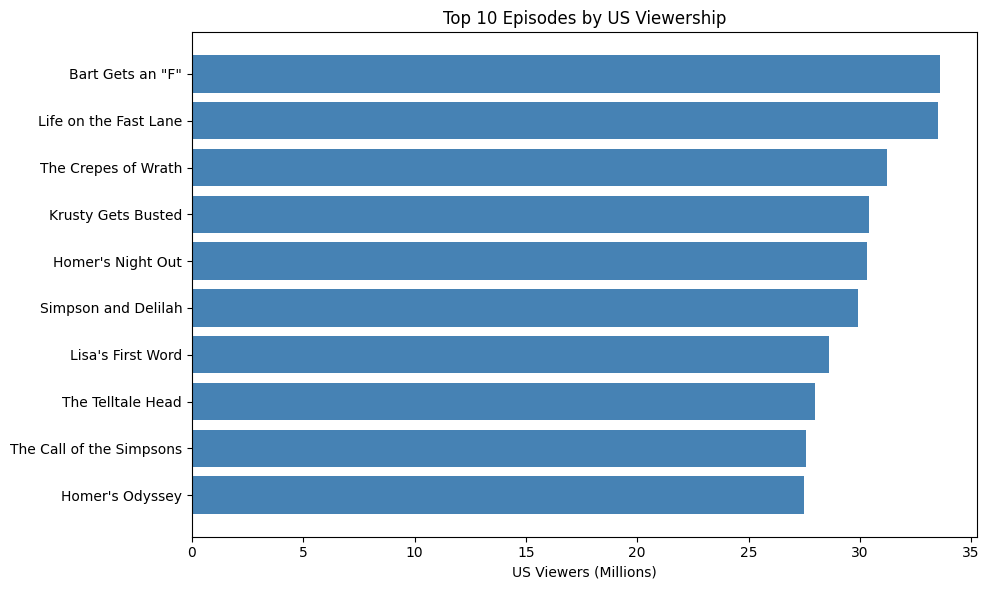

In [90]:
import os
import httpx
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

url = "https://raw.githubusercontent.com/Walendziak1912/Simpson-DataSets/master/simpsons_episodes.csv"

# Use httpx (requests won't work in Pyodide)
response = httpx.get(url)
response.raise_for_status()

# Save to file
with open("simpsons.csv", "w", encoding="utf-8") as f:
    f.write(response.text)

df = pd.read_csv(r'simpsons.csv')
# Drop rows with missing US viewers
df_clean = df.dropna(subset=['us_viewers_in_millions'])

# Get top 10 episodes by US viewers
top_10 = df_clean.nlargest(10, 'us_viewers_in_millions')

# Sort for better plotting (highest at top)
top_10_sorted = top_10.sort_values('us_viewers_in_millions', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_10_sorted['title'], top_10_sorted['us_viewers_in_millions'], color='steelblue')
plt.xlabel('US Viewers (Millions)')
plt.title('Top 10 Episodes by US Viewership')
plt.tight_layout()
plt.savefig('top_10_us_viewers.png')